In [1]:
%matplotlib inline
import time
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [2]:
n,m = 30,30
e = 0.3
c_0 = 30
c_1 = 20
q_0 = 1
q_1 = 0.4
mu = 0.5

class Grid():
    def __init__(self):
        self.pheremones = np.zeros((n,m),dtype=float)
        self.food = np.zeros((n,m),dtype=int)
        # self.home = (random.randint(0,n),random.randint(0,m))
        self.home = (10, 20)

        self.food[5:15, 5:15] = 3
    
    def evaporate(self):
      self.pheremones -= e*self.pheremones
      self.pheremones = np.maximum(np.zeros_like(self.pheremones), self.pheremones)

In [3]:
class Ant():
    def __init__(self, loc):
        """Inicialize ant with start location and home location"""
        self.loc = loc
        self.home = loc
        self.dir = (1, 0)
        self.hasfood = False
    
    def plot(self):
        """Puts down a dot for this ant. Red means it has food,
        green means it does not"""
        if self.hasfood:
            color = 'red'
        else:
            color = 'green'
        plt.scatter(self.loc[1], self.loc[0], color=color)

    def move(self, grid):
        """Move ant:
                Home: if has food
                Away From Home: If it smells something
        """
        # Calculate move probability
        l0 = max(0, min(self.loc[0]-self.dir[1], grid.pheremones.shape[0]-1))
        l1 = max(0, min(grid.pheremones.shape[0]-1, self.loc[1]+self.dir[0]))
        r0 = max(0, min(grid.pheremones.shape[0]-1, self.loc[0]+self.dir[1]))
        r1 = max(0, min(grid.pheremones.shape[0]-1, self.loc[1]-self.dir[0]))
        f0 = min(grid.pheremones.shape[0]-1, max(0, self.loc[0]+self.dir[0]))
        f1 = max(0, min(grid.pheremones.shape[0]-1, self.loc[1]-self.dir[1]))

        # left = grid.pheremones[self.loc[0]-self.dir[1], self.loc[1]+self.dir[0]]
        # right = grid.pheremones[self.loc[0]+self.dir[1], self.loc[1]-self.dir[0]]
        # front = grid.pheremones[self.loc[0]+self.dir[0], self.loc[1]-self.dir[1]]
        left = grid.pheremones[l0, l1]
        right = grid.pheremones[r0, r1]
        front = grid.pheremones[f0, f1]
        p_m = 0.5 * (1 + np.tanh((left + right + front)/0.5 - 1))

        if np.random.choice(2,1,p=[1-p_m,p_m]):
          c = (mu + left)**2 + (mu + right)**2 + (mu + front)**2
          p_left = 1/c * (mu + left)**2
          p_right = 1/c * (mu + right)**2
          p_front = 1 - p_left - p_right

          left_loc = (self.loc[0]-self.dir[1], self.loc[1]+self.dir[0])
          right_loc = (self.loc[0]+self.dir[1], self.loc[1]-self.dir[0])
          front_loc = (self.loc[0]+self.dir[0], self.loc[1]-self.dir[1])

          # Update location
          next_loc = np.random.choice(["left_loc","right_loc","front_loc"],1,p=[p_left,p_right,p_front])
          if next_loc == "left_loc":
            self.loc = left_loc
          elif next_loc == "right_loc":
            self.loc = right_loc
          else:
            self.loc = front_loc

          # if 0 <= next_loc[0] < self.pheremones.size()[1] and 0 <= next_loc[1] < self.pheremones.size()[0]:
            # self.loc = next_loc
            
        # Drop the food if we made it home
        if self.loc == self.home:
            self.hasfood = False


In [4]:
class Anthill():
    """Class designating the anthill which contains ants."""
    Ants = []
    grid = np.array(1)

    def __init__(self, food='', numants=100):
        """Initialize anthill with either a food aray and number of ants."""
        self.grid = Grid()
        for _ in range(numants):
            self.Ants.append(Ant(self.grid.home))

    def simulate(self, iterations=1):
        """Run the simulation an input number of iterations (default 1)"""
        worldshape = self.grid.food.shape
        fig, _ = plt.subplots(figsize=(10, 20))
        for _ in range(iterations):

            for ant in self.Ants:
              old_dir = ant.loc
              ant.move(self.grid)
              if ant.loc[0] < 0:
                  ant.loc = (0, ant.loc[1])
              if ant.loc[0] == worldshape[0]:
                  ant.loc = (worldshape[0]-1, ant.loc[1])
              if ant.loc[1] < 0:
                  ant.loc = (ant.loc[0], 0)
              if ant.loc[1] == worldshape[1]:
                  ant.loc = (ant.loc[0], worldshape[1]-1)
              
              # Update dir
              # ant.dir = (ant.loc[0]-old_dir[0], ant.loc[1]-old_dir[1])

              # Get food if reaches food souce and ant has no food
              if self.grid.food[ant.loc[0], ant.loc[1]] > 0:
                if not ant.hasfood:
                    self.grid.food[ant.loc[0], ant.loc[1]] -= 1
                    ant.dir = (ant.dir[0]*-1, ant.dir[1]*-1) # Flips direction
                    ant.hasfood = True
              
              # Deposit pheremone at new location
              if ant.hasfood:
                if self.grid.pheremones[ant.loc[0], ant.loc[1]] < c_1:
                  self.grid.pheremones[ant.loc[0], ant.loc[1]] += q_1
              else:
                if self.grid.pheremones[ant.loc[0], ant.loc[1]] < c_0:
                  self.grid.pheremones[ant.loc[0], ant.loc[1]] += q_0
              
              # Evaporate pheremone
              self.grid.evaporate()

            self.show()

            # Animaiton part
            clear_output(wait=True) # Clear output for dynamic display
            display(fig)            # Reset display
            fig.clear()             # Prevent overlapping and layered plots
            time.sleep(0.0001)      # Sleep to allow animation to catch up
            
    def show(self):
        "Show the location of the food and the Ants"
        plt.imshow(self.grid.food)
        plt.scatter(self.grid.home[1], self.grid.home[0], color='blue')
        for ant in self.Ants:
            ant.plot()

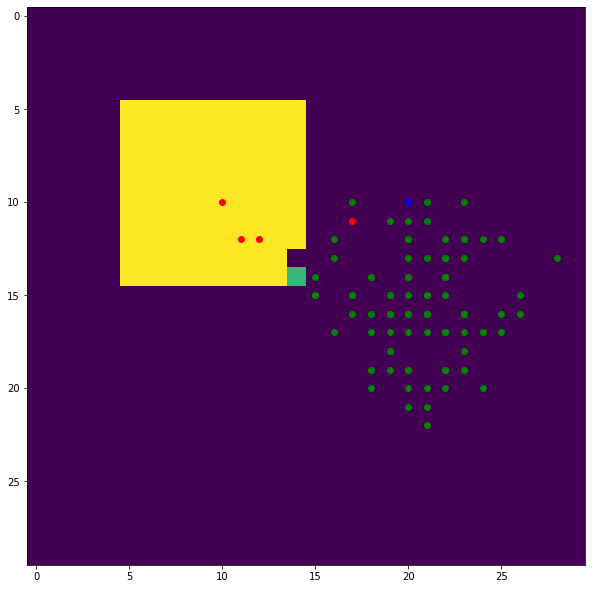

In [ ]:
hill = Anthill()
hill.simulate(1000)